# Homework 1

## FINM 36700 - 2023

### UChicago Financial Mathematics

**Professor**
* Mark Hendricks
* hendricks@uchicago.edu

**Students**

Kaleem Bukhari kbukhari@uchicago.edu

Aditya Murarka adityam@uchicago.edu

Raafay Uqaily raafay@uchicago.edu

Shrey Jain shreyjain@uchicago.edu

Tikhonov Sergei tikhonov@uchicago.edu


## Modules

In [57]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from arch.univariate import GARCH
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import matplotlib.pyplot as plt

# Helping functions

In [5]:
def performance_summary(return_data):

    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [6]:
def regression_based_performance(factor,fund_ret,rf,constant = True):

    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [7]:
def tangency_portfolio_rfr(asset_return,cov_matrix):

    asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num


## Data Reading

In [28]:
data = pd.read_excel('dfa_analysis_data.xlsx', 
                        sheet_name = 'factors', 
                        index_col = 'Date')
riskfree = data['RF']
data.drop('RF', axis = 1, inplace = True)

data_capm = pd.read_excel('dfa_analysis_data.xlsx', 
                        sheet_name = 'portfolios (total returns)', 
                        index_col = 'Date')

# The Factors

DFA believes certain stocks have higher expected excess returns. In addition to the overall market equity premium, DFA believes that there is a premium attached to a “size” and “value” factor. Note that these three factors are already listed as excess returns.1
]
Use the data found in **‘dfa analysis data.xlsx’**.

* FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^m$. The sheet also contains data on two additional factors, SMB and HML, as well as the risk-free rate. You do not need any of these columns for the homework. Just use the MKT column, which is excess market returns. (So no need to subtract the risk-free rate.)


### 2.1 Calculate their univariate performance statistics:
- ### mean
- ### volatility
- ### Sharpe
- ### VaR(.05)

In [25]:
performance_summary(data)[['Mean', 'Volatility', 'Sharpe Ratio', 'VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.081421,0.185140,0.439779,-0.08022
SMB,0.022779,0.109802,0.207459,-0.04206
HML,0.041191,0.123780,0.332780,-0.04210


### Report these for the following three subsamples:
- ### Beginning - 1980
- ### 1981 - 2001
- ### 2002 - End

In [26]:
sub_1980 = data.loc[:'1980']
sub_2001 = data.loc['1981':'2001']
sub_2023 = data.loc['2002':]

df_dict={'1926-1980' : sub_1980,
         '1981-2001' : sub_2001,
         '2002-2023' : sub_2023}

summary_lst = []
for key in df_dict.keys():
    summary_stats = performance_summary(df_dict[key]).loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]
    summary_stats['Period'] = key
    summary_stats= summary_stats.reset_index().rename(columns = {'index':'Factor'}).set_index(['Period','Factor'])
    summary_lst.append(summary_stats)

factor_summary = pd.concat(summary_lst)
factor_summary

Mean  Volatility  Sharpe Ratio  VaR (0.05)
Period    Factor                                                
1926-1980 Mkt-RF  0.081138    0.205050      0.395696   -0.083985
          SMB     0.033985    0.114568      0.296638   -0.043400
          HML     0.049479    0.133825      0.369727   -0.042910
1981-2001 Mkt-RF  0.077257    0.157396      0.490847   -0.064545
          SMB    -0.000862    0.118346     -0.007283   -0.046515
          HML     0.063776    0.111183      0.573612   -0.041790
2002-2023 Mkt-RF  0.086187    0.155313      0.554923   -0.079130
          SMB     0.017486    0.086443      0.202280   -0.038230
          HML    -0.001710    0.107517     -0.015901   -0.041740

### 2.2) Based on the factor statistics above, answer the following.

### 2.2.a) Does each factor have a premium (positive expected excess return) in each subsample?

In all three considered periods, only two factors showed negative expected excess returns:

1. Size (1981-2001). 

2. Value (2002-2023).

Though both expected excess returns were negative, the discounts were very low, close to zero. 

### 2.2.b) Does the premium to the size factor get smaller after 1980?

Yes, the premium of the size factor became smaller (in fact, it became negative, -0.000862) after than it was before (0.033985). 

### 2.2.c) Does the premium to the value factor get smaller during the 1990's?

The premium to value factor increases in the sub-sample of 1981-2001 as compared to 1926-1980, but then experiences a significant decline after the 2002 Dot-com Bubble. Since then, Size factor has been representing small (close to zero) mean excess returns. 

### 2.2.d) How have the factors performed since the time of the case, (2002-present)?

1. **Market factor**. Market factor still provides the highest premiums compared to both Value and Size factors. 

2. **Size factor**. Size factor starts providing positive premiums after the long period of negative premiums. 

3. **Value factor**. On the other hand, value factor becomes negative. The economic measures, which were implemented to prevent the consequences of the Great Recession, have led to companies trading farther away from their fundamentals, thus the value factor becomes unprofitable.

### 2.3) The factors are constructed in such a way as to reduce correlation between them. 

### Report the correlation matrix across the three factors. Does the construction method succeed in keeping correlations small? 

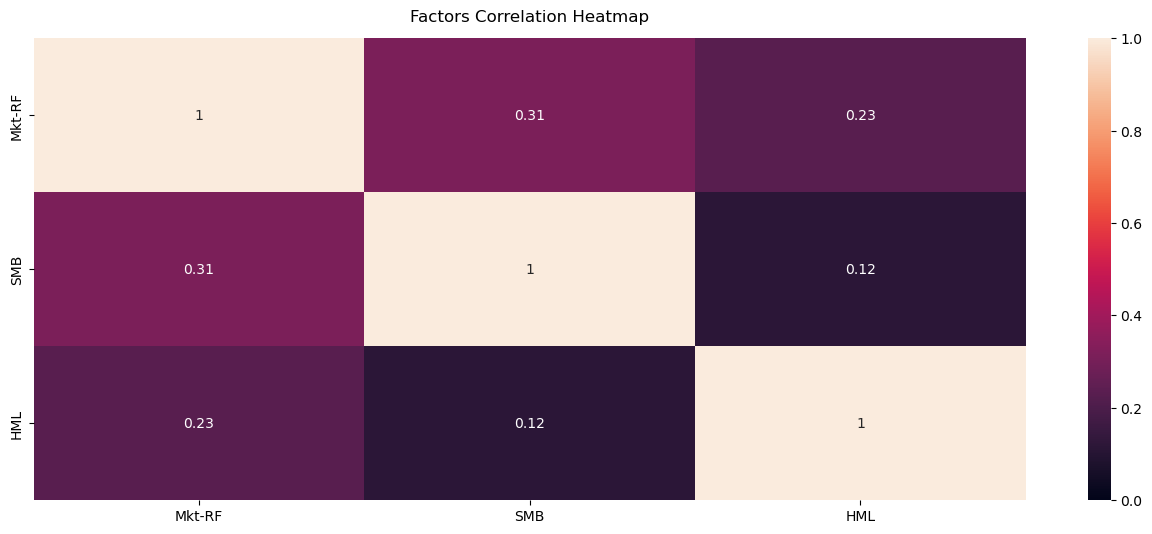

In [58]:
factor_corr = factors.corr()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(factor_corr, vmin=0, vmax=1, annot=True)
heatmap.set_title('Factors Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Does the construction method succeed in keeping correlations small? 

To sum up, the correlations between the three factors (Market, size, and value) are low, hence the construction method succeeds in its objective. 

### Does it achieve this in each subsample?

Apart from 1981-2001, the constuction method achieved low correlations. Considering 1981-2001, there is relatively high (in absolute values) correlation between Market and Value, as well as Value and Size. 

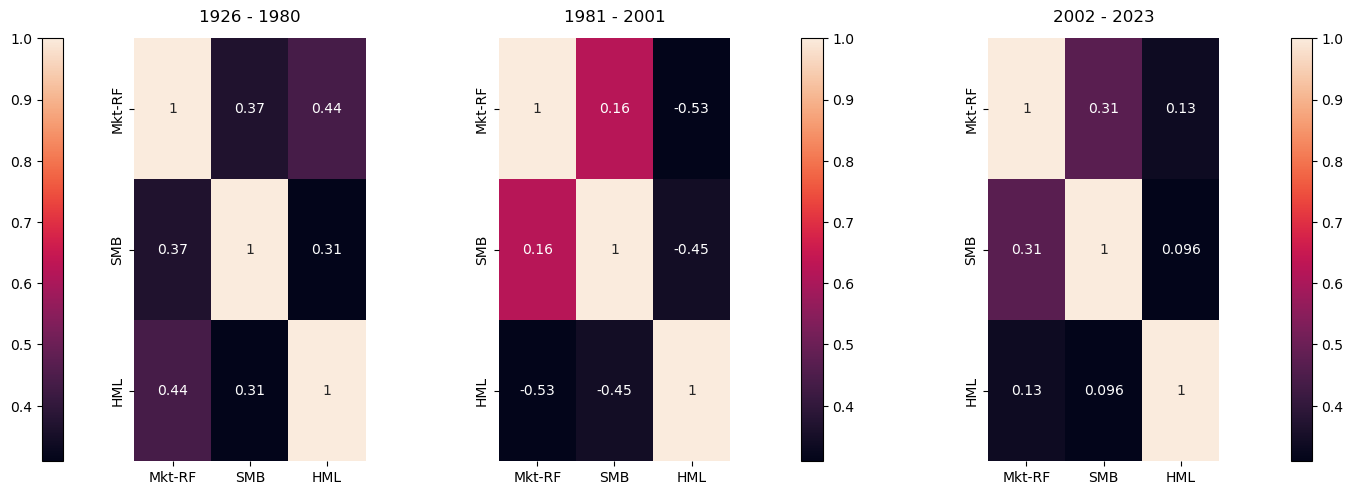

In [63]:
fig, (ax,ax2,ax3) = plt.subplots(ncols=3)

fig.subplots_adjust(wspace=0.01)
fig.tight_layout(pad=1)
sns.heatmap(sub_1980.corr(), ax=ax, cbar=False, annot = True).set_title('1926 - 1980', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(sub_2001.corr(), ax=ax2, cbar=False, annot = True).set_title('1981 - 2001', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0],ax=ax2,location="right", use_gridspec=False, pad=0.2)

sns.heatmap(sub_2023.corr(), ax=ax3, cbar=False, annot = True).set_title('2002 - 2023', fontdict={'fontsize':12}, pad=12);
fig.colorbar(ax.collections[0],ax=ax3,location="right", use_gridspec=False, pad=0.2)

fig.set_figwidth(15)
plt.show()

### 2.4) Plot the cumulative returns of the three factors. 

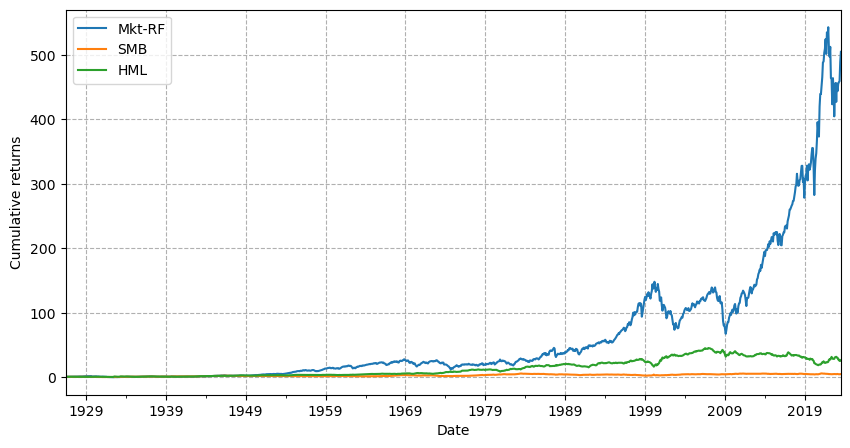

In [73]:
data = ((factors + 1).cumprod())
data.plot(figsize=(10, 5))
plt.grid(visible=1, linestyle='--')
plt.ylabel('Cumulative returns')
plt.xlabel('Date');

### Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

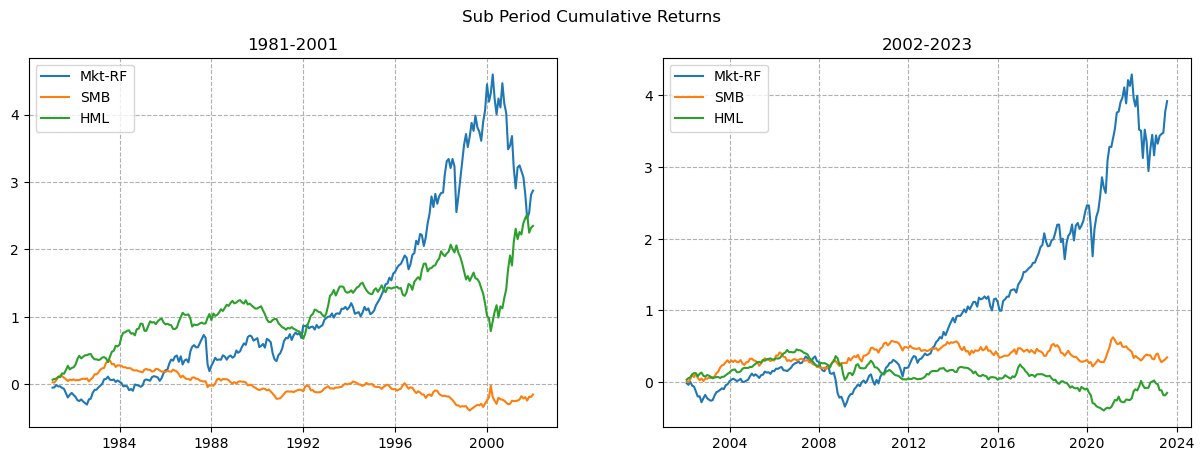

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sub Period Cumulative Returns')
ax1.plot(((sub_2001 + 1).cumprod() - 1))
ax2.plot(((sub_2023 + 1).cumprod() - 1))

fig.set_figwidth(15)
ax1.legend(sub_2001.columns)
ax1.grid(visible=1, linestyle='--')
ax2.legend(sub_2023.columns)

ax1.title.set_text('1981-2001')
ax2.grid(visible=1, linestyle='--')
ax2.title.set_text('2002-2023')

### 2.5) Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors?

1. Market Factor is crucial in both samples. There were two significant downsides: the Tech Bubble and the Great Recession. After those crises, it recovers very quickly. Market factor greatly outperforms both Value and Size facotrs in 1995 - 2001 and 2013-2023.

2. Value factor also plays an important role in both 1981-2001 and 2002-2023 samples. It strickly outperforms the Size factor in the first subsample, while in the second subsample, the Size factor represents higher cumulative returns.

3. Size factor also shows some relevant characteristics. Even though it was negative or close to zero in 1981-2001, it becomes positive in 2002-2023. Compared to other factors, the size factor is less volatile.

Even though all 3 factors still possess some relevant characterisitics, a few changes can be done. Firstly, the size factor seems out of favor for a long time now and the returns seem correlated to the Market Factor (though, in general relations highly depend on macroeconomic and financial characteristics). Secondly, other factors can be taken into account, such as volatility, liquidity, momentum, etc.


## 3. CAPM

#### DFA believes that premia in stocks and stock portfolios is related to the three factors. Let's test 25 equity portfolios that span a wide range of size and value measures

- #### PORTFOLIOS: Monthly total return data on 25 equity portfolios sorted by their size-value characteristics. Denote these as $r^{i}$, for n = 1,....,25.
- #### Note that while the factors were given as excess returns, the portfolios are total returns.
- #### For this entire problem, focus on the 1981-Present subsample.

### 3.1) Summary Statistics.

### For each portfolio,

- ### Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.
- ### Calculate the (annualized) univariate statistics from 1.1.

### Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.

In [38]:
data_capm_rf = data_capm.sub(riskfree, axis = 0)
data_capm_rf.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.056048,-0.019206,0.002675,-0.016780,0.018334,0.009877,0.021992,0.002726,-0.028249,-0.005544,...,0.013693,0.013078,0.010778,0.000527,0.022478,0.032339,0.058702,0.018066,0.028911,0.003423
1926-08-31,-0.022706,-0.082782,0.011296,0.012106,0.081468,0.021118,-0.014349,0.037584,0.002538,0.059175,...,0.010836,0.036230,0.017521,0.019206,0.050922,0.007624,0.039403,0.017631,0.052349,0.075076
1926-09-30,-0.050591,-0.028454,-0.045717,-0.035029,0.006349,-0.028840,-0.014918,0.008529,-0.037780,-0.011701,...,0.008623,-0.007550,-0.019936,0.012346,0.006430,-0.015206,0.034238,-0.001350,-0.009787,-0.026584
1926-10-31,-0.096929,-0.038719,-0.038148,0.031213,-0.028676,-0.031269,-0.035863,-0.053945,-0.083391,-0.016413,...,-0.036561,-0.029759,-0.024270,-0.034251,-0.056725,-0.030613,-0.033271,-0.025637,-0.049919,-0.061329
1926-11-30,0.052788,0.038777,0.021523,-0.047594,0.002262,0.027933,-0.026790,0.026978,0.048446,0.024192,...,0.031348,0.020787,0.034235,0.046220,0.015113,0.039846,0.022226,0.012104,0.033519,0.022536


### Calculate the (annualized) univariate statistics from 1.1.

In [39]:
port_summary = performance_summary(data_capm_rf.loc['1981-01-01':])
port_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
SMALL LoBM,0.008607,0.272612,0.031572,-0.121077
ME1 BM2,0.091784,0.235700,0.389411,-0.095709
ME1 BM3,0.092669,0.197915,0.468227,-0.085817
ME1 BM4,0.117387,0.192404,0.610105,-0.076442
SMALL HiBM,0.129434,0.208295,0.621397,-0.088647
ME2 BM1,0.059889,0.244792,0.244654,-0.103985
ME2 BM2,0.101862,0.204197,0.498842,-0.084928
ME2 BM3,0.107086,0.184794,0.579484,-0.079119
ME2 BM4,0.108899,0.180701,0.602648,-0.077423
ME2 BM5,0.116268,0.213841,0.543715,-0.096701


### Can the difference in mean excess returns of the portfolios be explained by differences in their volatilities? Or by their VaR(.05) statistics?

In [45]:
X = sm.add_constant(port_summary['Volatility'])
y = port_summary['Mean']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Mean   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     5.249
Date:                Fri, 20 Oct 2023   Prob (F-statistic):             0.0314
Time:                        12:54:25   Log-Likelihood:                 60.394
No. Observations:                  25   AIC:                            -116.8
Df Residuals:                      23   BIC:                            -114.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1672      0.032      5.183      0.000       0.100       0.234
Volatility    -0.3749      0.164     -2.291      0.031      -0.713      -0.036
==============================================================================
Omnibus:                        2.288   Durbin-Watson:                   1.518
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.213
Skew:                          -0.523   Prob(JB):                        0.545
Kurtosis:                       3.266   Cond. No.                         37.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
X = sm.add_constant(port_summary['VaR (0.05)'])
y = port_summary['Mean']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Mean   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     8.062
Date:                Fri, 20 Oct 2023   Prob (F-statistic):            0.00929
Time:                        12:55:12   Log-Likelihood:                 61.580
No. Observations:                  25   AIC:                            -119.2
Df Residuals:                      23   BIC:                            -116.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1754      0.029      6.053      0.000       0.115       0.235
VaR (0.05)     0.9711      0.342      2.839      0.009       0.264       1.679
==============================================================================
Omnibus:                        0.735   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.692   Jarque-Bera (JB):                0.292
Skew:                          -0.264   Prob(JB):                        0.864
Kurtosis:                       3.014   Cond. No.                         80.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Volatility**: Let's have a look at the coefficient at Volatility. It's p-value is close to 0.03, so if we choose the level of significance to be less than 0.03, the hypothesis is not rejected, while if the level of significance to be higher than 0.03, the hypothesis is rejected. As a result, we can conclude that the difference in mean excess returns of the portfolios can partially be explained by differences in their volatilities, but the relationship between the variables is relatively weak.

**VaR (0.05)**: Let's have a look at the coefficient at VaR. It's p-value is close to zero, so the significance hypothesis is rejected at any reasonable level of significance.

### 3.2 CAPM

#### The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio's) expected excess return is completely a function of its beta to the equity market index (SPY, or in this case, MKT.)
#### Specifically, it asserts that, for any excess return, $\tilde{r}^{i}$, its mean is proportional to the mean excess return of the market, $\tilde{r}^{m}$, where the proporitonality is the regression beta of $\tilde{r}^{i}$ on $\tilde{r}^{m}$.

#### <center>$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta \mathop{\mathbb{E}}[\tilde{r}^{m}_{t}]$</center>
#### Let's examine whether that seems plausible.

### 3.2.a) For each of the n = 25 test portfolios, run the CAPM time-series regression: <br> 
###   <center> $\tilde{r}_{t}^{i}$ = $α^{i} + β^{i,m}\tilde{r}^{m}_{t} + ε_{t}$ </center>
### So you are running 25 separate regressions, each using the T-sized sample of time-series data.

In [50]:
portfolios = data_capm_rf.columns
factor = data['1981-01-01':]['Mkt-RF']

df_lst= []
for port in portfolios:
    fund_ret = data_capm_rf.loc['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    beta = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst.append(pd.DataFrame([[beta,alpha,r_squared,treynor_ratio,information_ratio]],columns=['Market Beta','Alpha','R-Squared','Treynor Ratio','Information Ratio'],index = [port]))


### 3.2.b) Report the estimated $β^{i,m}$, Treynor Ratio, $α^{i}$, and Information Ratio for each of the n regressions.

In [51]:
reg_performance = pd.concat(df_lst)
reg_performance

,Market Beta,Alpha,R-Squared,Treynor Ratio,Information Ratio
SMALL LoBM,1.350120,-0.101808,0.598400,0.006375,-0.589319
ME1 BM2,1.160335,-0.003108,0.591270,0.079101,-0.020651
ME1 BM3,1.034045,0.008100,0.665975,0.089618,0.070829
ME1 BM4,0.967278,0.038280,0.616611,0.121358,0.321317
SMALL HiBM,0.988304,0.048612,0.549235,0.130966,0.347576
ME2 BM1,1.333429,-0.049164,0.723908,0.044914,-0.382220
ME2 BM2,1.128858,0.009540,0.745617,0.090235,0.092637
ME2 BM3,1.024793,0.023280,0.750294,0.104495,0.252046
ME2 BM4,0.970403,0.029532,0.703593,0.112220,0.300229
ME2 BM5,1.109383,0.025536,0.656627,0.104805,0.203817


### 3.2.c) If CAPM were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

**Treynor Ratios**: Just dividing by beta, we can notice that we've received Treynor Ratio:
$$
TR^{i} = \frac{\mathbb E(\tilde{r}^{i})}{\beta^{i,m}} = \mathbb E(\tilde{r}^{m})
$$

Here we can see that the TR of i's asset depends only on expected excess market returns, which do not depend on i. That is why TR should be equal for all assets. However, we can see that Treynor Ratios vary considerably among different assets. 

**Alpha**: Theoretically, all alphas must be equal to zero. Since we are eastimating on data, we receive the point estimates and it would be better to check their confidence intervals (whether noise is in corresponding confidence interval). However, here we see that alphas differ from zero (some are more close to zero, some are further from zero) without conducting this additional analysis.

**Information Ratio**: since this regression-based ratio is the ratio of alpha to volatility of unexplained return, we should expect that it also must be zero as alpha is zero (theoretically). However, we can see that many Information ratios vary from zero substantially. 

### 3.3) Cross-sectional Estimation

#### Let's test (CAPM) directly. We already have what we need:

- #### The dependent variable, (y): mean excess returns from each of the n = 25 portfolios.
- #### The regressor, (x): the market beta from each of the n = 25 time-series regressions.

- #### Then we can estimate the following equation:

<center> $  \underbrace{\mathop{\mathbb{E}}[\tilde{r}^{i}]}_\text{n x 1 data} = 
    \underbrace{\eta}_\text{regression intercept} +
    \underbrace{\beta^{i,m}}_\text{n x 1 data} *\underbrace{\lambda_{m}}_\text{regression estimate} + \underbrace{\upsilon}_\text{n x 1 residuals}
 $ </center>
 
- #### Note that we use sample means as estimates of $\mathop{\mathbb{E}}[\tilde{r}^{i}]$.
- #### This is a weird regression! The regressors are the betas from the time-series regressions we already ran!
- #### This is a single regression, where we are combining evidence across all n = 25 series. Thus, it is a cross-sectional regression!
- #### The notation is trying to emphasize that the intercept is different than the time-series $\alpha$ and that the regressor coefficient is different than the time-series betas.

### 3.2.a) Report the R-squared of this regression.
### 3.2.b) Report the intercept, $\upsilon$.
### 3.2.c) Report the regression coefficient, $\lambda_{m}$.

In [54]:
fund_ret = data_capm_rf.loc['1981-01-01':].mean()
factor = reg_performance['Market Beta']

reg = regression_based_performance(factor, fund_ret, 0)
beta = reg[0][0]
treynor_ratio = reg[1]
information_ratio = reg[2]
alpha = reg[3]
r_squared = reg[4]

cross_sec_reg = pd.DataFrame([[r_squared, alpha / 12, beta]],
                             columns = ['R-Squared', 'Intercept', 'Lambda'],
                             index = ['Cross-Sectional Estimation'])
cross_sec_reg

,R-Squared,Intercept,Lambda
Cross-Sectional Estimation,0.272833,0.016986,-0.008656


###  What would these three statistics be if (CAPM) were true?

**RSquared**: Low R-Squared from the cross-sectional regression indicates the presence of other risk factors in the market that can explain excess returns of equity portfolios. These could be firm-specific factors, industry-specific factors, or other systematic risk factors not captured by the market beta.

**Intercept and Lambda**: Theoretically, intercept must be equal to zero, because risk premia are proportional to market beta, and lambda (the proportionality) is equal to market risk premium:
$$
\mathbb E(\tilde{r}^{i}) = \beta^{i, m} \lambda_m = \beta^{i, m} \mathbb E(\tilde{r}^{m})
$$
So theoretically, in the following regression:
$$
\mathbb{E}[\tilde{r}^{i}] = 
    \eta +
    \beta^{i,m} * \lambda_{m} + \upsilon
$$
This should be hold:
$$
\eta = 0 \quad \quad \lambda_m = \mathbb E(\tilde{r}^{m})
$$
As was discussed on the lecture, after estimating the aforementioned regression, intercept is more than zero and lambda is too small relative to the full CAPM theory.

### 3.4) Broadly speaking, do these results support DFA's belief in size and value portfolios containing premia unrelated to the CAPM?

As was mentioned in the previous question, low RSquared and high intercept indicate the presence of other risk factors in the market that can explain excess returns of equity portfolios. Such results allow us to believe that other factors, such as probably size and value portfolios, that contain premia unrelated to the CAPM. To prove the observation, one can test Fama-French 3-Factor Model.